In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

import re
import string

import os

from collections import Counter
import types
import pandas as pd

In [3]:
train_data = pd.read_csv('train_data.csv')
train_data.head()  

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
test_data = pd.read_csv('test_data.csv')

test_data.head(2)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51


In [5]:
print("Number of data points in train data", train_data.shape)
print('-'*50)
print("The attributes of data :", train_data.columns.values)

Number of data points in train data (54808, 14)
--------------------------------------------------
The attributes of data : ['employee_id' 'department' 'region' 'education' 'gender'
 'recruitment_channel' 'no_of_trainings' 'age' 'previous_year_rating'
 'length_of_service' 'KPIs_met >80%' 'awards_won?' 'avg_training_score'
 'is_promoted']


<h2>Exploratory Data Analysis</h2>

<h3>Univariate Analysis</h3>

In [6]:
count_pro = train_data['is_promoted'].value_counts()
count_pro

0    50140
1     4668
Name: is_promoted, dtype: int64

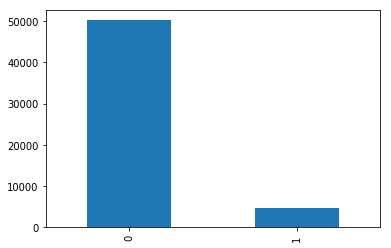

In [7]:
train_data["is_promoted"].value_counts().plot.bar()

As we can see from above graph, the HR data is an imbalanced dataset.
Where people promoted are very less as compared to not promoted. So, we need to to upsampling.

In [8]:
train_data.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [9]:
train_data.head(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0


previous_year_rating emp who have 5 rating mark them as os,4-ec, 3 - hvc, 2 - meets req, 1 - need improvement

**Feature Engineering**

In [10]:
from datetime import date, datetime

current_year = date.today().year

train_data['birth_year'] =  abs(train_data['age'].subtract(current_year))

Getting year of birth from age

In [11]:
avg_age_reg = train_data.groupby('region').age.mean().to_dict()
train_data['avg_age_reg'] = train_data.region.apply(lambda x: avg_age_reg[x])

In [12]:
avg_age_gen = train_data.groupby('gender').age.mean().to_dict()
train_data['avg_age_gen'] = train_data.gender.apply(lambda x: avg_age_gen[x])

<h3>Bi-variate Analysis</h3>

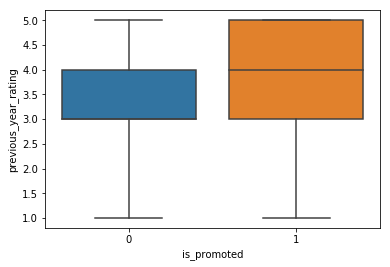

In [13]:
import seaborn as sb

ax = sb.boxplot(x= 'is_promoted', y='previous_year_rating',data=train_data, whis=np.inf)

**Employees who have got high rating are most likey to get promoted**

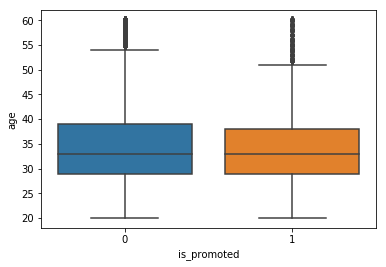

In [14]:
sb.boxplot(x= 'is_promoted', y='age',data=train_data)

**From the figure, there are outliers. But, usually a company have senior employees. So, we should not worry about this.**

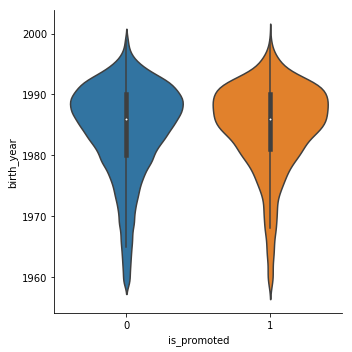

In [15]:
sb.catplot(x= 'is_promoted', y='birth_year', data=train_data, kind="violin")

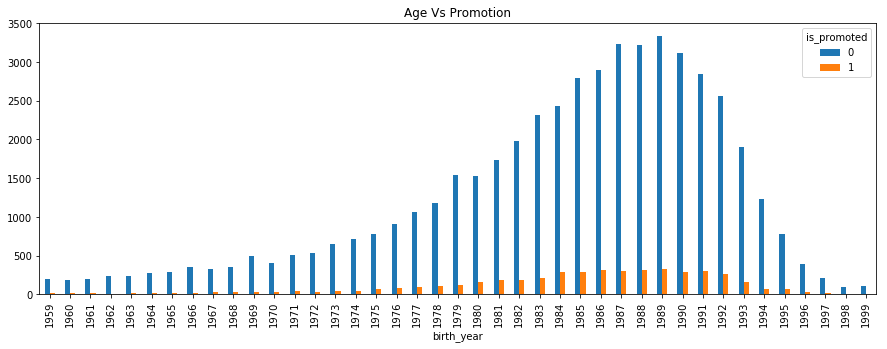

In [16]:
pd.crosstab(train_data.birth_year, train_data.is_promoted).plot(kind='bar', figsize = (15,5), \
                                                         label = 'Age Vs Promotion', title = 'Age Vs Promotion')

Left Skewed distribution

**Most number of employees are born in the year 1989**

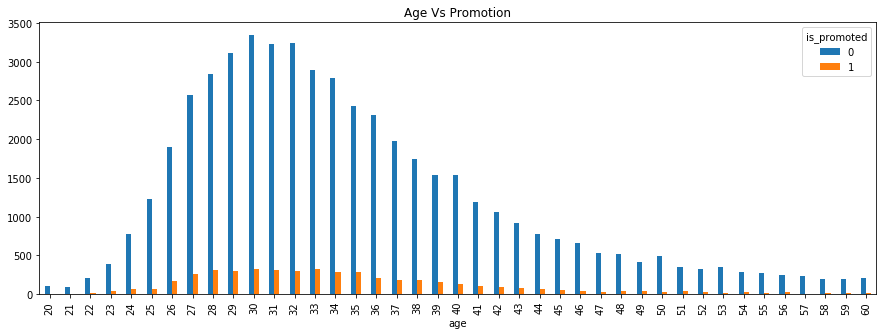

In [17]:
pd.crosstab(train_data.age, train_data.is_promoted).plot(kind='bar', figsize = (15,5), \
                                                         label = 'Age Vs Promotion', title = 'Age Vs Promotion')

Right skewed distribution

**As we can see above, most employees who get promoted are between age 27 to 36.**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DE8D537128>,
      dtype=object)

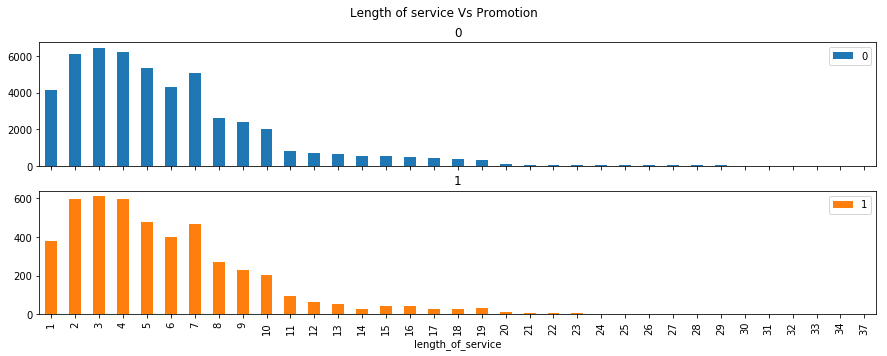

In [18]:
pd.crosstab(train_data.length_of_service, train_data.is_promoted).plot(kind='bar', subplots=True, figsize = (15,5), \
                                                                      title = 'Length of service Vs Promotion')

**Employees having experience 2-7 have promotion rates very high**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DE8D501C50>,
      dtype=object)

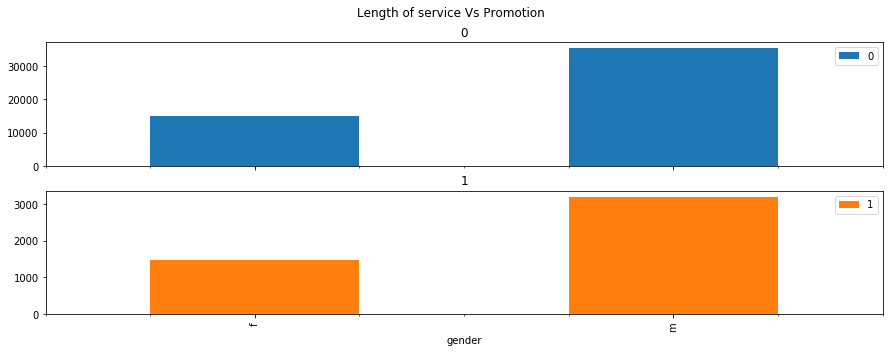

In [19]:
pd.crosstab(train_data.gender, train_data.is_promoted).plot(kind='bar', subplots=True, figsize = (15,5), \
                                                                      title = 'Length of service Vs Promotion')

**Here, we can clearly say that male employees are promoted more.**

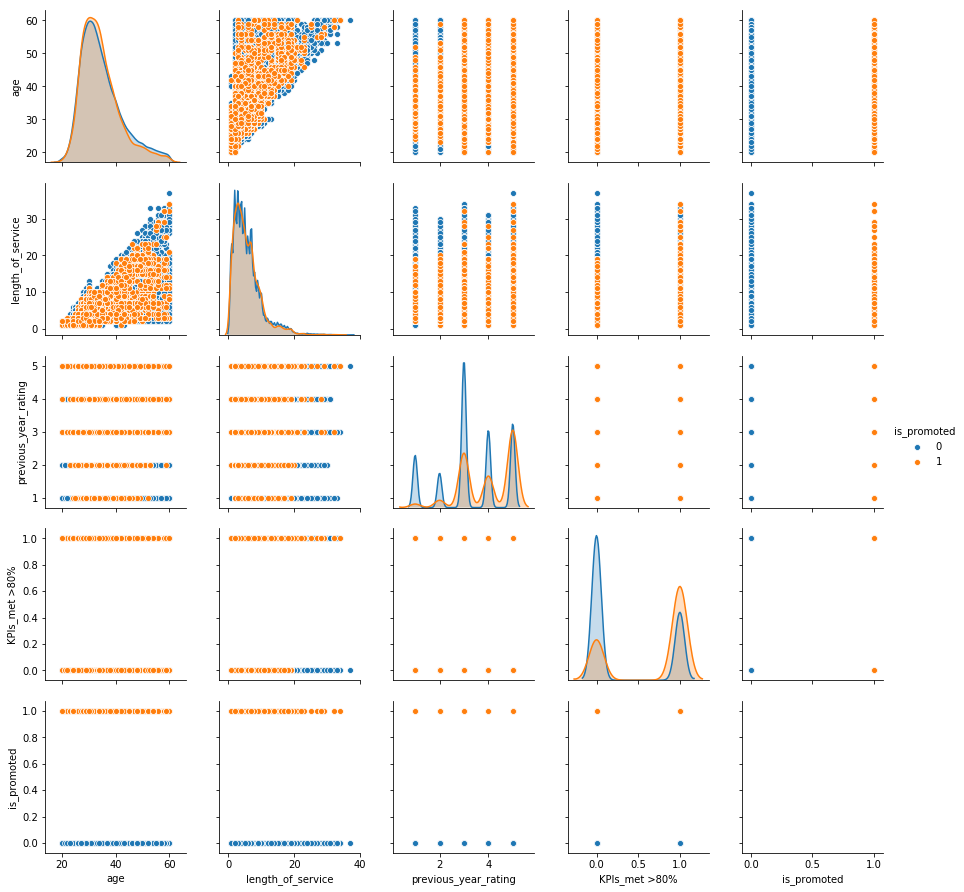

In [20]:
df = train_data[['age', 'length_of_service', 'previous_year_rating', 'KPIs_met >80%', 'is_promoted']]
sb.pairplot(df, hue="is_promoted")

In [21]:
corr = train_data.corr(method ='pearson')
corr.style.background_gradient(cmap='PuBu').set_precision(2)

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,birth_year,avg_age_reg,avg_age_gen
employee_id,1,-0.0051,0.00044,0.0045,0.0013,-0.0025,0.0084,-0.00059,0.0012,-0.00044,0.0012,0.0015
no_of_trainings,-0.0051,1,-0.081,-0.063,-0.057,-0.046,-0.0076,0.043,-0.025,0.081,0.02,-0.085
age,0.00044,-0.081,1,0.006,0.66,-0.026,-0.0082,-0.048,-0.017,-1,0.34,0.016
previous_year_rating,0.0045,-0.063,0.006,1,0.00025,0.35,0.028,0.075,0.16,-0.006,0.024,0.024
length_of_service,0.0013,-0.057,0.66,0.00025,1,-0.078,-0.04,-0.038,-0.011,-0.66,0.23,0.02
KPIs_met >80%,-0.0025,-0.046,-0.026,0.35,-0.078,1,0.097,0.078,0.22,0.026,0.0054,0.037
awards_won?,0.0084,-0.0076,-0.0082,0.028,-0.04,0.097,1,0.072,0.2,0.0082,-0.0011,-0.0024
avg_training_score,-0.00059,0.043,-0.048,0.075,-0.038,0.078,0.072,1,0.18,0.048,-0.015,0.024
is_promoted,0.0012,-0.025,-0.017,0.16,-0.011,0.22,0.2,0.18,1,0.017,0.01,0.011
birth_year,-0.00044,0.081,-1,-0.006,-0.66,0.026,0.0082,0.048,0.017,1,-0.34,-0.016


Correlation metric used is Pearson.

Newly created feature birth_year has 0.017 of correlation with target variable.

Feature which is most important in deciding promotion is KPIs met.


<h2>Upsampling</h2>

In [22]:
from sklearn.utils import resample

train_data_majority = train_data[train_data.is_promoted==0]
train_data_minority = train_data[train_data.is_promoted==1]

# Upsample minority class
train_data_minority_upsampled = resample(train_data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=count_pro[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train_data = pd.concat([train_data_majority, train_data_minority_upsampled])
 
# Display new class counts
train_data.is_promoted.value_counts()

1    50140
0    50140
Name: is_promoted, dtype: int64

In [23]:
train_data.shape

(100280, 17)

<h3>Pre-Processing Data</h3>

**Department**

In [24]:
catogories = list(train_data['department'].values)

cat_list = []
for i in catogories:
    temp = ""

    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','')
        temp+=j.strip()+" " 
        temp = temp.replace('&','_')
    cat_list.append(temp.strip())
    
train_data['clean_department'] = cat_list
train_data.drop(['department'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in train_data['clean_department'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [25]:
train_data.head(3)

,employee_id,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,birth_year,avg_age_reg,avg_age_gen,clean_department
0,65438,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,1984,35.644229,34.995647,Sales_Marketing
1,65141,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,1989,32.321251,34.722672,Operations
2,7513,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,1985,36.113272,34.722672,Sales_Marketing


In [26]:
train_data['clean_department'].unique()

array(['Sales_Marketing', 'Operations', 'Technology', 'Analytics', 'R_D',
       'Procurement', 'Finance', 'HR', 'Legal'], dtype=object)

In [27]:
train_data.isnull().any()

employee_id             False
region                  False
education                True
gender                  False
recruitment_channel     False
no_of_trainings         False
age                     False
previous_year_rating     True
length_of_service       False
KPIs_met >80%           False
awards_won?             False
avg_training_score      False
is_promoted             False
birth_year              False
avg_age_reg             False
avg_age_gen             False
clean_department        False
dtype: bool

Education and Previous year rating have some missing values which we will be imputing.

<h3>Education</h3>

**Checking if the values of education**

In [28]:
train_data['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

In [29]:
a = train_data['education'].isnull().sum()
print("Number of people whose education qualification is not captured:", a)

Number of people whose education qualification is not captured: 3616


In [30]:
train_data['education'].value_counts()

Bachelor's          66076
Master's & above    29113
Below Secondary      1475
Name: education, dtype: int64

**Imputing values with most frequent**

In [31]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
Y = train_data['education'].values.reshape(-1, 1)
train_data['education'] = imp.fit_transform(Y)

In [32]:
train_data['education'].head()

0    Master's & above
1          Bachelor's
2          Bachelor's
3          Bachelor's
4          Bachelor's
Name: education, dtype: object

In [33]:
import re
education = list(train_data['education'].values)

cat_list = []
for i in education:
    temp = ""

    for j in i.split(','): 
        if 'The' in j.split():
            j = j.replace('The','')
        j = j.replace(' ','')
        temp+=j.strip()+" " 
        temp = temp.replace('&','_')
        temp = temp.replace("\'s",'s')
    cat_list.append(temp.strip())
    
train_data['clean_education'] = cat_list
train_data.drop(['education'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in train_data['clean_education'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_edu = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [34]:
train_data['clean_education'].head(3)

0    Masters_above
1        Bachelors
2        Bachelors
Name: clean_education, dtype: object

**Previous Year Rating**

In [35]:
pyr = train_data['previous_year_rating'].isnull().sum()
print("Number of people whose previous year rating is not captured:", pyr)

Number of people whose previous year rating is not captured: 7408


In [36]:
train_data['previous_year_rating'].value_counts()

3.0    31844
5.0    30503
4.0    17416
1.0     7087
2.0     6022
Name: previous_year_rating, dtype: int64

In [37]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X = train_data['previous_year_rating'].values.reshape(-1, 1)
train_data['previous_year_rating'] = imp.fit_transform(X)

In [38]:
train_data['previous_year_rating'].unique()

array([5., 3., 1., 4., 2.])

In [39]:
avg_age_dep = train_data.groupby('clean_department').age.mean().to_dict()
train_data['avg_age_dep'] = train_data.clean_department.apply(lambda x: avg_age_dep[x])

In [40]:
avg_age_edu = train_data.groupby('clean_education').age.mean().to_dict()
train_data['avg_age_edu'] = train_data.clean_education.apply(lambda x: avg_age_edu[x])

**Splitting data**

In [41]:
Y = train_data['is_promoted'].values
train_data.drop(['is_promoted'], axis=1, inplace=True)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, Y, test_size=0.33, stratify=Y)

In [43]:
X_train.head(3)

,employee_id,region,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,birth_year,avg_age_reg,avg_age_gen,clean_department,clean_education,avg_age_dep,avg_age_edu
13259,69286,region_31,m,sourcing,1,27,3.0,4,1,0,58,1992,33.047545,34.722672,Finance,Bachelors,31.504185,32.94602
18682,13833,region_13,m,sourcing,1,45,5.0,16,0,0,62,1974,35.743580,34.722672,Sales_Marketing,Bachelors,34.724031,32.94602
43816,9261,region_2,m,other,1,29,3.0,1,0,0,60,1990,38.811634,34.722672,Sales_Marketing,Bachelors,34.724031,32.94602


In [44]:
print(X_train.shape)
print(X_test.shape)

(67187, 18)
(33093, 18)


<h3>Vectorizing Categorical features</h3>

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_cat = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_cat.fit(X_train['clean_department'].values)

train_dep = vectorizer_cat.transform(X_train['clean_department'].values)
test_dep = vectorizer_cat.transform(X_test['clean_department'].values)

print(vectorizer_cat.get_feature_names())
print("="*100)
print("Shape of matrix after one hot encodig ",train_dep.shape, y_train.shape)
print("Shape of matrix after one hot encodig ",test_dep.shape, y_test.shape)

['Legal', 'R_D', 'HR', 'Finance', 'Analytics', 'Procurement', 'Technology', 'Operations', 'Sales_Marketing']
Shape of matrix after one hot encodig  (67187, 9) (67187,)
Shape of matrix after one hot encodig  (33093, 9) (33093,)


In [46]:
vectorizer_cat = CountVectorizer(vocabulary=list(sorted_cat_edu.keys()), lowercase=False, binary=True)
vectorizer_cat.fit(X_train['clean_education'].values)

train_edu = vectorizer_cat.transform(X_train['clean_education'].values)
test_edu = vectorizer_cat.transform(X_test['clean_education'].values)


print(vectorizer_cat.get_feature_names())
print("="*100)
print("Shape of matrix after one hot encodig ",train_edu.shape, y_train.shape)
print("Shape of matrix after one hot encodig ",train_edu.shape, y_test.shape)

['BelowSecondary', 'Masters_above', 'Bachelors']
Shape of matrix after one hot encodig  (67187, 3) (67187,)
Shape of matrix after one hot encodig  (67187, 3) (33093,)


In [47]:
vectorizer_cat = CountVectorizer(lowercase=False, binary=True)
vectorizer_cat.fit(X_train['region'].values)

train_reg = vectorizer_cat.transform(X_train['region'].values)
test_reg = vectorizer_cat.transform(X_test['region'].values)


print(vectorizer_cat.get_feature_names())
print("="*100)
print("Shape of matrix after one hot encodig ",train_reg.shape, y_train.shape)
print("Shape of matrix after one hot encodig ",train_reg.shape, y_test.shape)

['region_1', 'region_10', 'region_11', 'region_12', 'region_13', 'region_14', 'region_15', 'region_16', 'region_17', 'region_18', 'region_19', 'region_2', 'region_20', 'region_21', 'region_22', 'region_23', 'region_24', 'region_25', 'region_26', 'region_27', 'region_28', 'region_29', 'region_3', 'region_30', 'region_31', 'region_32', 'region_33', 'region_34', 'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9']
Shape of matrix after one hot encodig  (67187, 34) (67187,)
Shape of matrix after one hot encodig  (67187, 34) (33093,)


In [48]:
vectorizer_cat = CountVectorizer(lowercase=False, binary=True)
vectorizer_cat.fit(X_train['recruitment_channel'].values)

train_rc = vectorizer_cat.transform(X_train['recruitment_channel'].values)
test_rc = vectorizer_cat.transform(X_test['recruitment_channel'].values)


print(vectorizer_cat.get_feature_names())
print("="*100)
print("Shape of matrix after one hot encodig ",train_rc.shape, y_train.shape)
print("Shape of matrix after one hot encodig ",train_rc.shape, y_test.shape)

['other', 'referred', 'sourcing']
Shape of matrix after one hot encodig  (67187, 3) (67187,)
Shape of matrix after one hot encodig  (67187, 3) (33093,)


In [49]:
X_train['gen'] = np.where(X_train['gender'] == 'm', '1', '0')
X_test['gen'] = np.where(X_test['gender'] == 'm', '1', '0')

In [50]:
train_gender = X_train['gen'].values.reshape(-1,1)
test_gender = X_test['gen'].values.reshape(-1,1)

<h3>Normalizer</h3>

In [51]:
train_awards = X_train['awards_won?'].values.reshape(-1,1)
test_awards = X_test['awards_won?'].values.reshape(-1,1)

In [52]:
train_trng_norm = X_train['no_of_trainings'].values.reshape(-1,1)
test_trng_norm = X_test['no_of_trainings'].values.reshape(-1,1)

In [53]:
train_age = X_train['age'].values.reshape(-1,1)
test_age = X_test['age'].values.reshape(-1,1)

In [54]:
train_pyr = X_train['previous_year_rating'].values.reshape(-1,1)
test_pyr = X_test['previous_year_rating'].values.reshape(-1,1)

In [55]:
train_los = X_train['length_of_service'].values.reshape(-1,1)
test_los = X_test['length_of_service'].values.reshape(-1,1)

In [56]:
train_kpi = X_train['KPIs_met >80%'].values.reshape(-1,1)
test_kpi = X_test['KPIs_met >80%'].values.reshape(-1,1)

In [57]:
train_avg_trng = X_train['avg_training_score'].values.reshape(-1,1)
test_avg_trng = X_test['avg_training_score'].values.reshape(-1,1)

In [58]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

train_gen = normalizer.transform(X_train['gen'].values.reshape(-1,1))
test_gen = normalizer.transform(X_test['gen'].values.reshape(-1,1))

print(train_gen.shape, y_train.shape)
print(test_gen.shape, y_test.shape)
print("="*100)

(67187, 1) (67187,)
(33093, 1) (33093,)


In [59]:
train_emp_id = X_train['employee_id'].values.reshape(-1,1)

test_emp_id = X_test['employee_id'].values.reshape(-1,1)

print(train_emp_id.shape, y_train.shape)
print(train_emp_id.shape, y_test.shape)
print("="*100)

(67187, 1) (67187,)
(67187, 1) (33093,)


In [60]:
train_age_gen = X_train['avg_age_gen'].values.reshape(-1,1)
train_age_reg = X_train['avg_age_reg'].values.reshape(-1,1)
train_age_dep = X_train['avg_age_dep'].values.reshape(-1,1)
train_age_edu = X_train['avg_age_edu'].values.reshape(-1,1)
train_birth = X_train['birth_year'].values.reshape(-1,1)

In [61]:
test_age_gen = X_test['avg_age_gen'].values.reshape(-1,1)
test_age_reg = X_test['avg_age_reg'].values.reshape(-1,1)
test_age_dep = X_test['avg_age_dep'].values.reshape(-1,1)
test_age_edu = X_test['avg_age_edu'].values.reshape(-1,1)
test_birth = X_test['birth_year'].values.reshape(-1,1)

In [62]:
from scipy.sparse import hstack
X_tr = hstack((train_emp_id, train_birth, train_age_gen, train_age_reg, train_age_dep, train_age_edu, train_trng_norm, train_gen, train_avg_trng, train_kpi, train_los, train_pyr, train_age, train_awards, train_edu, train_rc, train_reg, train_dep)).tocsr()
X_te = hstack((test_emp_id, test_birth, test_age_gen, test_age_reg, test_age_dep, test_age_edu, test_trng_norm, test_gen, test_avg_trng, test_kpi, test_los, test_pyr, test_age, test_awards, test_edu, test_rc, test_reg, test_dep)).tocsr()

In [63]:
# Confusion Matrix
def predict_chek(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

<h3>Feature Engineering</h3>

In [64]:
from sklearn.preprocessing import PolynomialFeatures
X = X_tr

poly = PolynomialFeatures(2)
X_tr1 = poly.fit_transform(X)

In [65]:
X = X_te

poly = PolynomialFeatures(2)
X_te1 = poly.fit_transform(X)

In [66]:
X_te1.shape

(33093, 2080)

<h3>XGBoost</h3>

In [67]:
start = datetime.now()

tuned_parameters = {'n_estimators' : [20,50,80,100,150], 'max_depth' : [3,5,8,10,12]}

model = XGBClassifier()
clf = GridSearchCV(model, tuned_parameters, cv=StratifiedKFold(3), return_train_score= True, scoring = 'f1')
clf.fit(X_tr1, y_train)

y_pred_acc = clf.predict(X_te1)

print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

print('Time taken :', datetime.now() - start)

F1 Score : 0.9333333333333335
Time taken : 1:05:24.902213


In [68]:
print(clf.best_params_)
print('-'*50)
print(clf.best_estimator_)

{'max_depth': 12, 'n_estimators': 150}
--------------------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


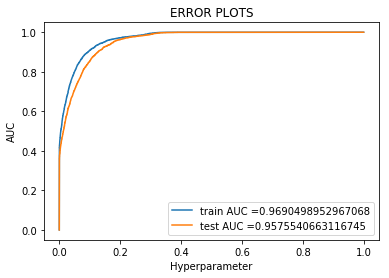

In [69]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state= 42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

model.fit(X_tr1, y_train)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, model.predict_proba(X_tr1)[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, model.predict_proba(X_te1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [70]:
y_pred_test = model.predict(X_te1)
y_pred_train = model.predict(X_tr1)

print('F1 Score test: ' + str(f1_score(y_test,y_pred_test)))
print('F1 Score train: ' + str(f1_score(y_train,y_pred_train)))

F1 Score test: 0.8880810323296794
F1 Score train: 0.8985984021231305


Text(0.5, 1.0, 'Confusion matrix Test')

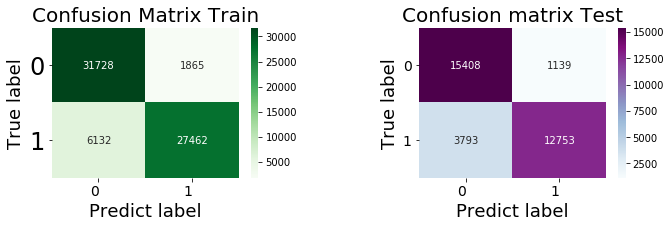

In [71]:
plt.figure(figsize = (9,3))
plt.subplot(121)
cnf_matrix = metrics.confusion_matrix(y_train, predict_chek(model.predict_proba(X_tr1)[:,1], tr_thresholds, train_fpr, train_tpr))
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greens" ,fmt='g')
p.yaxis.set_ticklabels(p.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=24)
p.xaxis.set_ticklabels(p.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix Train",size=20)


plt.tight_layout(pad = 0.1, w_pad = 12, h_pad = 0.5)
plt.subplot(122)
cnf_matrix = metrics.confusion_matrix(y_test, predict_chek(model.predict_proba(X_te1)[:,1], te_thresholds, test_fpr, test_tpr))
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuPu" ,fmt='d')
p.yaxis.set_ticklabels(p.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
p.xaxis.set_ticklabels(p.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion matrix Test",size=20)

**Conclusion**

1. As we increased the number of features the accuracy also improved.

2. Feature Engineering holds the utmost importance.

3. We have done upsampling of datapoints as the given dataset is highly imbalanced. This holds true in any organization as number of employees getting promoted will be very less.

4. By upsampling the performance has been improved significantly.

6. We have imputed missing values by most frequent values.

7. We realized that normaliation is not required in XGBOOST as without normalizing numerical data the accuracy/ f1 score improved drastically.

Saving model in pickel file

In [75]:
import pickle
pickle.dump(model, open('model.pkl','wb'))

In [77]:
model_pick = pickle.load(open('model.pkl','rb'))
# print(model_pick.predict([[2, 9, 6]]))